### Topic: Extension of demon algorithm on OD matrices and comparicon with the gravity model
### Author: Ivana Benova
### Last edits: 03.05.2021

In [1]:
#importation of libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import math
import pandas as pd
import scipy
from scipy.spatial import distance_matrix
import time
from matplotlib import ticker
from numba import jit

### Definition of functions - gravity model 

In [2]:
'''Genration of population of zones between 100 and max_size
    Inputs: type_OD -string, according to the characteristic of population, OD_random is number
                     generated from uniform distribution, O=D=1000 is constant population of 1000,
                     O=D_linear is linear growth of population,
            max_size - integer, maximal number of inhabitants of zone, 
            num_cities - integer, number of zones,
            OD_relation - string, according to characteristic of population, equal is O=D, 
            start_O=100, 
            growth_0=200, 
            start_D=400, 
            growth_D=50 - parameters in case of linar growth of population

    Outputs:O - numpy array, vector of origin,
            D - numpy array, vector of destination'''
def population_of_cities(type_OD, max_size, num_cities, OD_relation, start_O=100, growth_0=200, start_D=400, growth_D=50):
    if type_OD == 'OD_random':
        O = np.sort(np.random.randint(100,max_size, num_cities))
        if OD_relation == 'equal':
            D = O.copy()
        else:
            D = np.sort(np.random.randint(100,max_size, num_cities))
            D = D*(O.sum()/D.sum())
    if type_OD == 'O=D=1000':
        O = 1000*np.ones(num_cities)
        D = O.copy()
    if type_OD == 'O=D_linear':
        O = start_O+growth_0*np.arange(num_cities)
        if OD_relation == 'equal':
            D = O.copy()
        else:
            D = start_D + growth_D*np.arange(num_cities)
            D = D*(O.sum()/D.sum())
    return O,D

In [3]:
'''Generation of coordinates with constant spacing on the streight line or with growing spacing on the streight
line or with random distribution on the streight line or randomly distributed over space
    Inputs: seed - integer, random seed,
            num_cities - integer, number of zones,
            type - string, type of generation, konstant is constant spacing on the streight line,
            zvacsuj is growing spacing on the streight line, nahodne_x is x-coordinate randomly generated form
            normal distribution y- coordinate is constant, nahodne is normal distribution of both coordinates, 
            coef - float, constant spacing between zones, 
            distance_of_cities - float, distance between zones that is aritmeticaly growing, 
            sigma=50 - sigma of normal distribution,
            
    Outputs:x-numpy array, vector of x-coordinates,
            y-numpy array, vector of y-coordinates'''
def generation_of_coordinates(seed, num_cities, type, coef, distance_of_cities, sigma=50):
    np.random.seed(seed)
    if type == 'konstant':
        x = np.array([0])
        y = np.zeros(num_cities)
        for i in np.arange(num_cities-1):
            x = np.append(x,x[-1]+coef)
    if type == 'zvacsuj':
        x = np.array([0])
        y = np.zeros(num_cities)
        for i in np.arange(num_cities-1):
            x = np.append(x,x[-1]+distance_of_cities*(i+1))
    if type == 'nahodne_x':
        x = np.random.normal(0, sigma, num_cities)
        y = np.zeros(num_cities)
    if type == 'nahodne':
        x = np.random.normal(0, sigma, num_cities)
        y = np.random.normal(0, sigma, num_cities)
    return x,y
        

In [4]:
'''Entropy function
    Inputs: T_2 - numpy array, matrix
    
    Outputs: float, entropy '''
def entropy_function(T_2):
    TT = T_2.copy()
    TT[TT==0]=1
    return -np.sum(T_2*np.log(TT) - T_2) 

'''Entropy function in numba library for quick calculations'''
@jit(nopython=True)
def entropy_numba(T):
    N = T.sum()
    N1, N2 = T.shape
    S = 0
    for i in range(N1):
        for j in range(N2):
            if T[i,j] > 0.0:
                S -= T[i,j]*math.log(T[i,j]) - T[i,j] 
    return S    

In [5]:
'''Computation of the biggest relative deviation of sums of rows and columns of matrix from vectors
origin and destination
    Inputs: T_2 - numpy array, trip matrix,
            D - numpy array, vector of destination,
            O - numpy array, vector of origin, 
            
    Outputs: float, convergence rate '''
def kvg_function(T_2, D, O):
    return np.max([np.abs(np.divide(D,T_2.sum(axis=0))-1),np.abs(np.divide(O,T_2.sum(axis=1))-1)])

In [6]:
'''Calculation of trip matrix constraind by vectors origin and
destination for 20 iterations
    Inputs: T_2 - numpy array, trip matrix,
            D - numpy array, vector of destination,
            O - numpy array, vector of origin
            
    Outputs:T - numpy array, trip matrix after 20 iterations,
            it - integer, number of iterations
            entropy - numpy array, vector of entropies of trip matrix through iterations,
            kvg - numpy array, vector of convergence rate to O and D through iterations'''
def iterate_trip_matrix(T_2,D,O): 
    entropy = np.array([])
    kvg = np.array([])
    it = 0
    while it<20:
#       iteration by column
        T_2 = np.dot( T_2, np.diag( np.divide( D, T_2.sum( axis = 0 ) ) ) )
#       iteration by row
        T_2 = np.dot( np.diag( np.divide( O, T_2.sum( axis = 1 ) ) ), T_2 )
        it += 1
        entropy = np.append(entropy,entropy_function(T_2))
        kvg = np.append(kvg, kvg_function(T_2, D,O))

    return it, entropy, kvg, T_2

In [7]:
'''Function for calculating the average cost of trips
    Inputs: T - numpy array, matrix of trips,
            c - numpy array, matrix of costs,
            O - numpy array, vector of origin,
            
    Outputs:average cost'''
def average_costs(T,d,O):
    return np.array([np.sum(T*d)/np.sum(O)])

In [8]:
'''Deterrance function
    Inputs: p - integer, represents type of function 1-exponential, 2-power, 3-mixed,
            beta - integer, parameter of function,
            c - numpy array, matrix of costs,
            
    Outputs:matrix of detterence values'''
def trevel_costs_function(p, beta, c):
    if p == 1:
        f = np.exp( - beta * c )
    elif p == 2:
        f =  c ** ( -beta )
    else:
        f = c * np.exp( - beta * c ) 
    return f

In [9]:
'''Calculation of distance matrix using Euclidean norm
    Inputs: x- numpy array, vector of x-coordinates,
            y- numpy array, vector of y-coordinates,
            
    Outputs:d- numpy array, distance matrix'''
def distance_matrix_d(x,y):
    df = pd.DataFrame([x,y]).T
    d = distance_matrix(df.values, df.values)
    return d

In [10]:
'''Calculation of gravity model, 20 iterations
    Inputs: O - numpy array, vector of origin,
            D - numpy array, vector of destination,
            d- numpy array, distance matrix,
            OD_ relation - tring, relation of O and D, equal or not_equal,
            p - integer, represents type of function 1-exponential, 2-power, 3-mixed,
            c_star - desired average cost,
            alpha = 1 - float, parameter
            
    Output: kvg - numpy array, vector of convergence rate to O and D through iterations
            entropy - numpy array, vector of entropies of trip matrix through iterations,
            T_2 - numpy array, trip matrix after 20 iterations, 
            O - numpy array, vector of origin,
            d - numpy array, distance matrix,
            beta - float, parameter of function'''
def gravity_model( O, D, d, OD_relation, p, c_star, alpha = 1):
    
    num_cities = len(O)
#   starting value
    beta = np.array( [1 / c_star] )
    f = trevel_costs_function(p, beta[-1], d)
    T_2 = alpha * f
    it, entropy, kvg, T_2 = iterate_trip_matrix(T_2, D, O )
    c = np.array([average_costs(T_2,d,O)])
    iteration = 0
    
    while np.abs(c_star - c[-1])>=(c_star/10000):
        iteration += 1
        
        if iteration == 1:
#           function f(cij)
            f = trevel_costs_function(p, beta[-1], d)
#           matica T
            T_2 = alpha * f
#           iteration of trip matrix
            it, entropy, kvg, T_2 = iterate_trip_matrix(T_2, D, O)
            
            c = np.append(c, average_costs(T_2,d,O))
            beta = np.append(beta, beta[0]*(c[-1]/c_star))
    
        else:
#           function f(cij)
            f = trevel_costs_function(p, beta[-1], d)
#           matrix T
            T_2 = alpha * f
#           iteration of trip matrix
            it, entropy, kvg, T_2 = iterate_trip_matrix(T_2, D, O )
            c = np.append(c, average_costs(T_2,d,O))
            beta = np.append(beta, ((c_star-c[-2])*beta[-1]-(c_star-c[-1])*beta[-2])/(c[-1]-c[-2]))
            if (beta[-1]*d).min() < -50:
                print((beta[-1]*d).min())
                print('Large number in exponent, stop!')
                break
            
    return kvg, it, entropy, T_2, O, d, beta


### Definition of functions - Monte Carlo simulation for OD matrix

In [11]:
'''Initialization algorithm
    Input: seed - integer, random seed,
            num_cities - integer, number of zones,
            O - numpy array, vector of origin,
            D - numpy array, vector of destination,
            d- numpy array, distance matrix,
            wanted_avg_length - float, desired mean trip length
            
    Outputs: T- numpy array, initial trip matrix'''
def initial_matrix_T(seed, num_cities, O, D, d, wanted_avg_length):
    np.random.seed(seed)
    min_value_O = np.min(O)
    min_value_D = np.min(D)
    
    rows_complited = []
    columns_complited = []
    
    if min_value_O < min_value_D:
        min_value_T = min_value_O
    else:
        min_value_T = min_value_D
    T = (min_value_T/(2*num_cities))*np.ones((num_cities,num_cities))
    

    row_sum = T.sum(axis=1)
    
    column_sum = T.sum(axis=0)
    
    if ((O-row_sum)==0).any():
        rows_complited.append(np.where((O-row_sum)==0)[0][0])
    if ((D-column_sum)==0).any():
        columns_complited.append(np.where((D-column_sum)==0)[0][0])
    
    while ((O-row_sum>10**(-4)).any() | (D-column_sum>10**(-4)).any()):
        difference_O = O-row_sum
        difference_D = np.array(D-np.transpose(column_sum))
        if (difference_D<-1).any() | (difference_O<-1).any():
            print('Chyba')
        difference_O_min = difference_O[difference_O>0].min()
        difference_D_min = difference_D[difference_D>0].min()
        if difference_O_min < difference_D_min:
            index_O = np.where(difference_O==difference_O_min)[0][0]
            if ( index_O not in  rows_complited) & ( index_O not in columns_complited):
                T[index_O, index_O] += difference_O_min
            else:
                for i in np.arange(num_cities):
                    if i not in columns_complited:
                        T[index_O, i] += difference_O_min/(num_cities-len(columns_complited))
        else:
            index_D = np.where(difference_D==difference_D_min)[0][0]
            if ( index_D not in  rows_complited) & ( index_D not in columns_complited):
                T[index_D, index_D] += difference_D_min
            else:
                for i in np.arange(num_cities):
                    if i not in rows_complited:
                        T[i, index_D] += difference_D_min/(num_cities-len(rows_complited))
        
        row_sum = T.sum(axis=1)
        column_sum = T.sum(axis=0)
        
        if ((O-row_sum)<10**(-4)).any():
            for j in np.arange(len(np.where((O-row_sum)<10**(-4))[0])):
                rows_complited.append(np.where((O-row_sum)<10**(-4))[0][j])
            rows_complited = list(set(rows_complited))
        if ((D-column_sum)<10**(-4)).any():
            for j in np.arange(len(np.where((D-column_sum)<10**(-4))[0])):
                columns_complited.append(np.where(D-column_sum<10**(-4))[0][j])
            columns_complited = list(set(columns_complited))
    avg_length = avg_length_function(d,T)
    i = 0
    while ((wanted_avg_length- avg_length) < 0) | ((wanted_avg_length- avg_length)>wanted_avg_length/100):
        i += 1
        step = 1
        row = np.random.randint(0,num_cities)
        column = np.random.randint(0,num_cities)
        new_row = np.random.randint(0,num_cities)
        new_column = np.random.randint(0,num_cities)
        if ((T[row,column]>step) & (T[new_row, new_column]>step)):
            T[row,column] -= step
            T[row,new_column] += step
            T[new_row, new_column] -= step
            T[new_row, column] += step
            

            avg_length_new = avg_length_function(d,T)
            if (wanted_avg_length- avg_length) < 0: 
    
                if avg_length_new < avg_length:
                    avg_length = avg_length_new
                else:
                    T[row,column] += step
                    T[row,new_column] -= step
                    T[new_row, new_column] += step
                    T[new_row, column] -= step
            if ((wanted_avg_length- avg_length)>wanted_avg_length/100):
                if avg_length_new > avg_length:
                    avg_length = avg_length_new
                else:
                    T[row,column] += step
                    T[row,new_column] -= step
                    T[new_row, new_column] += step
                    T[new_row, column] -= step
        if i > 110000000:
            if (wanted_avg_length- avg_length) > 0:
                print('Too much iterations')
                print(avg_length)
                print(T)
                break
    return T

In [12]:
'''Calculation of the mean trip length in matrix in numba library
    Inputs: d - numpy array, distance matrix,
            T - numpy array, trip matrix,
            
    Outputs: float, the mean trip length'''
@jit(nopython=True)
def avg_length_function(d,T):
    return (np.sum(d*T))/np.sum(T)

In [13]:
'''one iteration of demon algorithm for OD matrix
    Inputs: step - float, size of step in iteration,
            num_cities - integer, number of zones,
            d - numpy array, distance matrix, 
            T - numpy array, trip matrix, 
            wanted_avg_length- float, desired mean trip length
            demon - numpy array, vector of energy values of demon through iterations,
            entropy - numpy array, vector of entropies of trip matrix through iterations,
            acc -integer, number of accepted iterations
    
    Outputs:demon - numpy array, vector of energy values of demon through iterations,
            entropy - numpy array, vector of entropies of trip matrix through iterations,
            T - numpy array, trip matrix,
            acc -integer, number of accepted iterations'''
@jit(nopython=True)
def demon_algoritm_on_matrix( step, num_cities, d, T, wanted_avg_length, demon, entropy, acc):
#   random generation of row and column
    
    row = np.random.randint(0,num_cities)
    column = np.random.randint(0,num_cities)
        
#   random generation of new row and column
    new_row = np.random.randint(0,num_cities)
    new_column = np.random.randint(0,num_cities)
    abs_length_0 = avg_length_function(d,T)*T.sum()
    
    
# relocation of step so the matrix will not have negative elements
    if ((T[row,column]>step) & (T[new_row, new_column]>step)):
        T[row,column] -= step
        T[row,new_column] += step
        T[new_row, new_column] -= step
        T[new_row, column] += step
            
#   the absolute trip length
        avg_length = avg_length_function(d,T)
        abs_length_1 = avg_length*T.sum()
        delta_abs_length = abs_length_0 -abs_length_1
        
#   if the delta of mean trip lengths is positive the change of state is accepted
        if delta_abs_length > 0:
            demon.append(demon[-1]+delta_abs_length)
            entropy.append(entropy_numba(T))
            acc += 1
            
#   if the delta is negative the step is accepted only if demon has enough energy saved
        else:
            if -delta_abs_length <= demon[-1]:
                demon.append(demon[-1]+delta_abs_length)
                entropy.append(entropy_numba(T))
                acc += 1
            else:
                T[row,column] += step
                T[row,new_column] -= step
                T[new_row, new_column] += step
                T[new_row, column] -= step
                
                demon.append(demon[-1])
                entropy.append(entropy[-1])
                
    return demon, entropy, T, acc

In [14]:
'''Generation of OD matrix using the Monte Carlo simulation
    Inputs: seed - integer, random seed, 
            O - numpy array, vector of origin, 
            D - numpy array, vector of destination, 
            d - numpy array, distance matrix, 
            T - numpy array, trip matrix, 
            wanted_avg_length - float, desired mean trip length, 
            max_it - integer, number of iterations, 
            start_it - integer, number of starting iterations,
            
    Outputs: T - numpy array, trip matrix, 
             demon - numpy, array, vector of values of energy of demon through iterations, 
             entropy - numpy array, vector of entropies of matrix through iterations, 
             acc - integer, number of accepted iterations, 
             T_sum - numpy array, matrix averaged over states when demon value was lower than threashold, 
             vector_of_steps - numpy array, vector of size of steps'''
@jit(nopython=True)
def generation_OD(seed, O, D, d, T, wanted_avg_length, max_it, start_it):
    np.random.seed(seed)
    num_cities = len(O)

#   mean trip length
    avg_length = avg_length_function(d,T)
    
#   demon - difference between desired and actual mean trip length
    demon = [wanted_avg_length*T.sum() - avg_length*T.sum()]
    entropy = [entropy_numba(T)]
    acc = 0
    T_sum = np.zeros((num_cities, num_cities))
    acc_porov = 0
    max_O = O.max()
    min_O = O.min()
    sum_O = O.sum()
    std_O = np.std(O)
    sum_coeff = 0
    interval = 90
    i = 0
    
#   starting iterations
    while i < start_it:
        i += 1
        if i < (start_it/60):
            step = 1
        else:
            if i%interval == 0:
                if acc/i < 0.85:
                    step = step*0.95
                else:
                    step = step*1.05
                    if step > 100:
                        step = 100
        demon, entropy, T, acc = demon_algoritm_on_matrix( step, num_cities, d, T, wanted_avg_length, demon, entropy, acc)
    
    demon = [wanted_avg_length*T.sum() - avg_length*T.sum()]
    entropy = [entropy_numba(T)]
    it = 0
    acc = 0
#    vector_of_steps = []

#   demon iteration repeated given number of times   
    while it< max_it:
        porov = acc
        it += 1
        if it < (max_it/60):
            step = 5
        elif it <(max_it-10000):
            if it%interval == 0:
                if acc/it < 0.85:
                    step = step*0.95
                else:
                    step = step*1.05
                    if step > 100:
                        step = 100
        else:
            step = 1
        demon, entropy, T, acc = demon_algoritm_on_matrix( step, num_cities, d, T, wanted_avg_length, demon, entropy, acc)
#        vector_of_steps.append(step)
        if ((demon[-1]<(wanted_avg_length*(T.sum()/25))) & (porov != acc) ):
            T_sum += T
#            T_sum += (1/(demon[-1]+1))*T
#            sum_coeff += (1/(demon[-1]+1))
            acc_porov += 1
    print(acc_porov)
    if acc_porov >0:
        T_sum = T_sum/acc_porov
#        T_sum = T_sum/sum_coeff
    return T, demon, entropy, acc, T_sum #, vector_of_steps

### Simulations

In [15]:
seed = 123
num_cities = 10
max_size = 2000
type_coords = 'konstant'
#type_coords = 'zvacsuj'
#type_coords = 'nahodne'
coef = 1
distance_of_cities = 0.8
wanted_avg_length = np.sqrt(10)
c_star = np.sqrt(10)
start_it = 1000000
max_it = 2000000
#type_OD = 'O=D=1000'
type_OD = 'O=D_linear'
#type_OD = 'O=D_random'
OD_relation = 'not_equal'


In [16]:
# generation of O and D vectors
O, D = population_of_cities(type_OD, max_size, num_cities, OD_relation)

# generation of coordinates
x,y = generation_of_coordinates(seed, num_cities, type_coords, coef, distance_of_cities)

# distance matrix
d = distance_matrix_d(x,y)

(array([-2.,  0.,  2.,  4.,  6.,  8., 10.]),
 <a list of 7 Text yticklabel objects>)

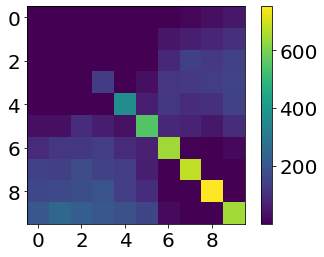

In [17]:
# initial matrix
np.random.seed(seed)
T = initial_matrix_T(seed, num_cities, O, D, d, wanted_avg_length)
T.astype(int)
T1 = plt.imshow(T)
cbar = plt.colorbar(T1, extend='neither', spacing='proportional',
                orientation='vertical', shrink=1, format="%.0f")
cbar.ax.tick_params(labelsize=20)
plt.xticks( fontsize=20)
plt.yticks( fontsize=20)
#plt.savefig('initial_T_O=D_linear_coords_constant_2,5.png')

In [18]:
T

array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.40000000e+01,
        3.10000000e+01, 4.80000000e+01],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 4.50000000e+01, 6.40000000e+01,
        8.00000000e+01, 1.05000000e+02],
       [1.00000000e+00, 5.00000000e-01, 5.00000000e-01, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 8.40000000e+01, 1.42000000e+02,
        1.24000000e+02, 1.45000000e+02],
       [1.42857143e-01, 5.00000000e-01, 3.57142857e-01, 1.34000000e+02,
        1.00000000e+00, 3.20000000e+01, 1.18000000e+02, 1.26000000e+02,
        1.37000000e+02, 1.51000000e+02],
       [1.42857143e-01, 5.00000000e-01, 3.57142857e-01, 1.00000000e+00,
        3.69000000e+02, 6.30000000e+01, 1.22000000e+02, 9.50000000e+01,
        1.03000000e+02, 1.46000000e+02],
       [3.21428571e+01, 3.15000000e+01, 9.43571429e+01, 5.70000000e+01,
   

In [19]:
T.sum(axis=1)

array([ 100.,  300.,  500.,  700.,  900., 1100., 1300., 1500., 1700.,
       1900.])

In [20]:
T.sum(axis=0)

array([ 640.,  720.,  800.,  880.,  960., 1040., 1120., 1200., 1280.,
       1360.])

In [21]:
np.sum(d*T)/np.sum(T)

3.1308

In [22]:
# Monte Carlo simulation
print(wanted_avg_length)
# matica OD
T = initial_matrix_T(seed, num_cities, O, D, d, wanted_avg_length)
print(T)
print('OK')
start_time = time.time()
T, demon, entropia, acc, T_sum = generation_OD(seed, O, D, d, T, wanted_avg_length, max_it, start_it)
end_time = time.time()
print(end_time-start_time)

3.1622776601683795
[[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00 1.40000000e+01
  3.10000000e+01 4.80000000e+01]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 4.50000000e+01 6.40000000e+01
  8.00000000e+01 1.05000000e+02]
 [1.00000000e+00 5.00000000e-01 5.00000000e-01 1.00000000e+00
  1.00000000e+00 1.00000000e+00 8.40000000e+01 1.42000000e+02
  1.24000000e+02 1.45000000e+02]
 [1.42857143e-01 5.00000000e-01 3.57142857e-01 1.34000000e+02
  1.00000000e+00 3.20000000e+01 1.18000000e+02 1.26000000e+02
  1.37000000e+02 1.51000000e+02]
 [1.42857143e-01 5.00000000e-01 3.57142857e-01 1.00000000e+00
  3.69000000e+02 6.30000000e+01 1.22000000e+02 9.50000000e+01
  1.03000000e+02 1.46000000e+02]
 [3.21428571e+01 3.15000000e+01 9.43571429e+01 5.70000000e+01
  3.30000000e+01 5.51000000e+02 8.40000000e+01 7.20000000e+01
  4.80000000e+01 9.70000000e+01]
 [9.11428571e+01 1.20500000e+02 1.21357

In [23]:
# symetrization of matrix
if (O == D).all():
    T_sum = (T_sum +np.transpose(T_sum))/2
print(T_sum.astype(int))

[[  9   9   9  12  10   9   8   8  11  10]
 [ 25  26  27  34  38  28  29  27  24  37]
 [ 50  42  43  50  47  49  65  41  58  50]
 [ 56  63  66  63  74  51  85  96  77  64]
 [ 55  87  75  89 107 109 126  74  90  83]
 [ 81  88  92  82 137 111 140 144 131  91]
 [ 75  81 115 127 150 127 131 149 171 169]
 [ 81 115 112 111 121 161 150 233 235 175]
 [ 99  97 116 164 132 180 166 223 226 292]
 [104 107 141 144 141 208 215 199 252 384]]


### Results

In [36]:
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

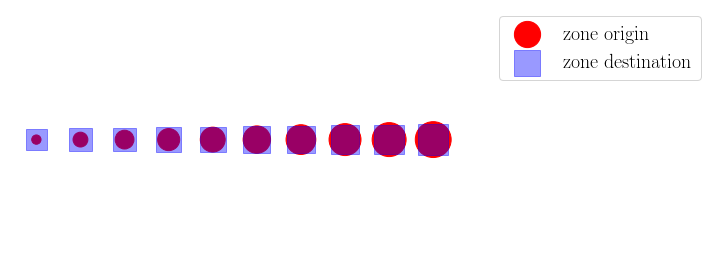

In [135]:
# map of zones
plt.figure(figsize = (10,4))
plt.scatter(x,y, color = 'red', s = 20+O/1.5, alpha = 1, label = 'zone origin')
plt.scatter(x,y, color = 'blue', s = 20+D/1.5, alpha = 0.4, label = 'zone destination',  marker = 's')
plt.axis("off")
#plt.xlabel(r"x-coordinate", size = 20)
#plt.ylabel(r"y-coordinate", size = 20)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
#plt.xticks(fontsize=20)
#plt.yticks(ticks = [0], fontsize=20)
plt.tight_layout()
#plt.savefig('map_O=D_linear_coords_constant.png')

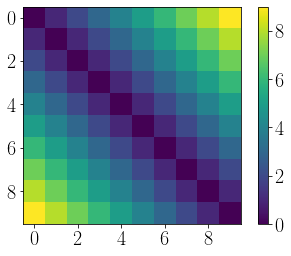

In [32]:
# distance matrix
image = plt.imshow(d)
cbar = plt.colorbar(image, extend='neither', spacing='proportional',
                orientation='vertical', shrink=1, format="%.0f")
plt.xticks( fontsize=20)
plt.yticks( fontsize=20)
cbar.ax.tick_params(labelsize=20) 
#plt.savefig('d_O=D_linear_coords_constant.png')

In [37]:
T_sum.sum(axis = 0)-D

array([-2.46473064e-10,  9.45874490e-11, -1.72803993e-11,  1.07320375e-10,
        3.33102435e-11,  1.20962795e-10, -6.27551344e-11, -4.05862011e-11,
       -1.00044417e-10, -1.92699190e-10])

In [38]:
T_sum.sum(axis = 1) -O

array([-2.46473064e-10,  9.45874490e-11, -1.75077730e-11,  1.07320375e-10,
        3.33102435e-11,  1.20962795e-10, -6.25277607e-11, -4.03588274e-11,
       -1.00044417e-10, -1.92699190e-10])

[Text(0, 0, '$0$'),
 Text(0, 0, '$100000$'),
 Text(0, 0, '$200000$'),
 Text(0, 0, '$300000$'),
 Text(0, 0, '$400000$'),
 Text(0, 0, '$500000$')]

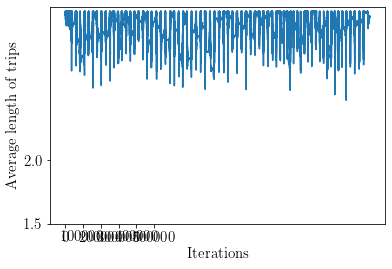

In [39]:
#mean trip length through iterations
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(len(demon)), (wanted_avg_length-demon/O.sum()))
ax.set_xlabel(r"Iterations", size = 15)
ax.set_ylabel(r"Average length of trips", size = 15)
xticks = [0, 100000, 200000, 300000, 400000, 500000]
yticks = [1.5, 2]
ax.set_yticks(yticks)
ax.set_xticks(xticks)
ax.set_yticklabels(["$%.1f$" % y for y in yticks], fontsize=15); # use LaTeX formatted labels
ax.set_xticklabels(["$%.0f$" % x for x in xticks], fontsize=15)
#ax.xaxis.set_major_formatter(formatter) 
#plt.savefig('length_O=D=1000_coords_constant.png')

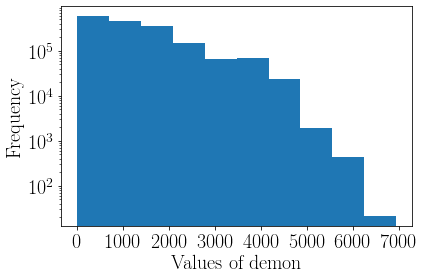

In [40]:
# energy of demon through iterations
fig, ax = plt.subplots(1, 1)
ax.hist(demon, bins = 10 )
plt.yscale('log')
ax.set_xlabel(r"Values of demon", size = 20)
ax.set_ylabel(r"Frequency", size = 20)
plt.xticks(fontsize=20)
plt.yticks( fontsize=20)
plt.tight_layout()
#plt.savefig('demon_O=D_linear_coords_constant_2.5.png')

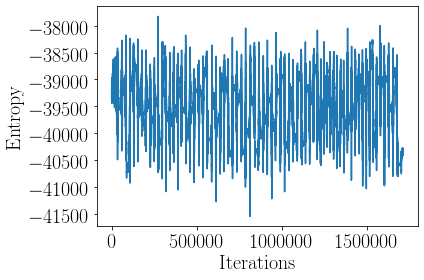

In [41]:
# entropy of matrix through iterations
plt.plot(np.arange(len(entropia)), np.array(entropia))
plt.xlabel(r"Iterations", size = 20)
plt.ylabel(r"Entropy", size = 20)
plt.yticks( fontsize = 20)
plt.xticks( ticks = [0, 500000, 1000000, 1500000], fontsize = 20)
#ax.set_yticklabels(["$%.1f$" % y for y in yticks], fontsize=15); # use LaTeX formatted labels
#ax.set_xticklabels(["$%.1f$" % x for x in xticks], fontsize=15)
#ax.yaxis.set_major_formatter(formatter) 
#ax.xaxis.set_major_formatter(formatter) 
plt.tight_layout()
#plt.savefig('entropy_O=D=1000_coords_constant_.png')

In [42]:
# step through iterations
N=10000
plt.plot( np.convolve(vector_of_steps, np.ones(N)/N, mode='valid'))
plt.xlabel(r"Iterations", size = 20)
plt.ylabel(r"Size of step", size = 20)
plt.yticks(fontsize = 20)
plt.xticks(ticks = [0, 500000, 1000000, 1500000, 2000000], fontsize = 20)
#ax.set_yticklabels(["$%.0f$" % y for y in yticks], fontsize=15); # use LaTeX formatted labels
#ax.set_xticklabels(["$%.0f$" % x for x in xticks], fontsize=15)
#ax.xaxis.set_major_formatter(formatter) 
plt.tight_layout()
#plt.savefig('step_O=D_linear_coords_constant_2.5.png')

NameError: name 'vector_of_steps' is not defined

In [44]:
# acceptance ration
acc/max_it

0.851325

In [47]:
# generation of OD matrix by gravity model
p = 1
start_time = time.time()

chyba, it, entropia_2, T_2, O_2, d_2, beta = gravity_model( O, D, d, OD_relation, p, c_star)

end_time = time.time()
print(end_time-start_time)

0.012995243072509766


In [50]:
max_ = (np.array([T_sum.max(),T_2.max()])).max()
#min_ = (np.array([T_sum.min(),T_2.min()])).min()
min_ = 0

(array([-2.,  0.,  2.,  4.,  6.,  8., 10.]),
 <a list of 7 Text yticklabel objects>)

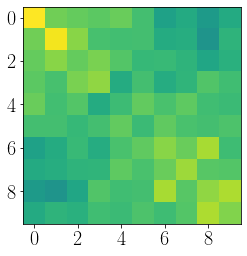

In [51]:
# OD matrix generated by Monte Carlo simulation
image = plt.imshow(T_sum, vmin = min_, vmax = max_)
#cbar = plt.colorbar(image, extend='neither', spacing='proportional',
#                orientation='vertical', shrink=1, format="%.0f")
plt.xticks( fontsize=20)
plt.yticks( fontsize=20)
#cbar.ax.tick_params(labelsize=15) 
#plt.savefig('Monte_Carlo_O=D_linear_coords_constant_2.5.png')

In [52]:
T_sum.sum(axis = 1) -O

array([-2.46473064e-10,  9.45874490e-11, -1.75077730e-11,  1.07320375e-10,
        3.33102435e-11,  1.20962795e-10, -6.25277607e-11, -4.03588274e-11,
       -1.00044417e-10, -1.92699190e-10])

In [53]:
T_sum.sum(axis = 0) -D

array([-2.46473064e-10,  9.45874490e-11, -1.72803993e-11,  1.07320375e-10,
        3.33102435e-11,  1.20962795e-10, -6.27551344e-11, -4.05862011e-11,
       -1.00044417e-10, -1.92699190e-10])

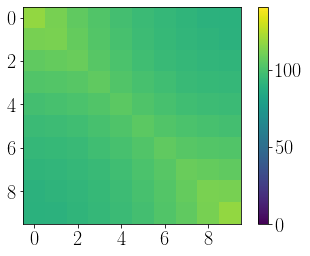

In [54]:
# OD matrix generated by gravity model
image = plt.imshow(T_2, vmin = min_, vmax = max_)
cbar = plt.colorbar(image, extend='neither', spacing='proportional',
                orientation='vertical', shrink=1, format="%.0f")
plt.xticks( fontsize=20)
plt.yticks( fontsize=20)
cbar.ax.tick_params(labelsize=20) 
#plt.savefig('Gravity_model_O=D_linear_coords_constant_2.5.png')

In [55]:
chyba_gravity_model = np.abs(np.sum(T_2.sum(axis=0)-O_2))
chyba_gravity_model

2.2737367544323206e-13

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


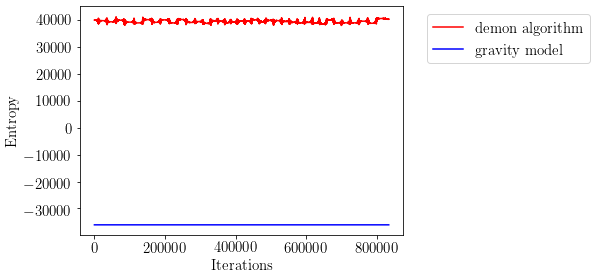

In [58]:
# comparison of entropies
dlzka = int((max_it/2.4))
entropia_2_obr = np.append(entropia_2,entropia_2[-1]*np.ones(dlzka-dlzka_2))
plt.figure(figsize = (8.5,4))
plt.plot(np.arange(dlzka), -np.array(entropia[-(dlzka+1):-1]), color = 'red', label = 'demon algorithm')
plt.plot(np.arange(dlzka), entropia_2_obr, color = 'blue', label = 'gravity model')
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15)
plt.xlabel(r"Iterations", size = 15)
plt.ylabel(r"Entropy", size = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
#ax.set_yticklabels(["$%.0f$" % y for y in yticks], fontsize=15); # use LaTeX formatted labels
#ax.set_xticklabels(["$%.0f$" % x for x in xticks], fontsize=15)
#ax.xaxis.set_major_formatter(formatter) 
plt.tight_layout()
#plt.savefig('compare_O=D=1000_coords_constant_2.png')

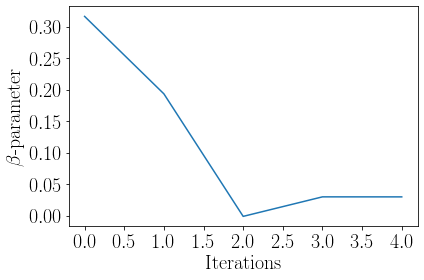

In [59]:
# beta parameter
plt.plot(np.arange(len(beta)), beta)
plt.xlabel(r"Iterations", size = 20)
plt.ylabel(r"$\beta$-parameter", size = 20)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
#ax.set_yticklabels(["$%.2f$" % y for y in yticks], fontsize=15); # use LaTeX formatted labels
#ax.set_xticklabels(["$%.0f$" % x for x in xticks], fontsize=15)
plt.tight_layout()
#plt.savefig('beta_O=D_linear_coords_constant_2.5.png')

### Comparison of matrices

In [61]:
# the mean trip length of gravity matrix
np.sum(d_2*T_2)/np.sum(T_2)

3.16211776895574

In [73]:
# the entropy of gravity matrix
entropia_2.mean()

-36072.385872020175

In [75]:
# maximum element of gravity matrix
T_2.max()

117.87662975669258

In [77]:
# minimum element of gravity matrix
T_2.min()

90.07998042793204

In [79]:
# Average element of gravity matrix
T_2.mean()

100.0

In [80]:
# standard deviation of elements of gravity matrix
T_2.std()

6.462991340519361

In [62]:
# the mean trip length of Monte Carlo matrix
np.sum(d*T_sum)/np.sum(T_sum)

3.0819573852591056

In [70]:
# entropy of Monte Carlo matrix
entropy_function(T_sum)

-36128.242188783566

In [74]:
# maximum element of Monte Carlo matrix
T_sum.max()

140.81664113429247

In [76]:
# minimum element of Monte Carlo matrix
T_sum.min()

72.93276896547818

In [78]:
# average element of Monte Carlo matrix
T_sum.mean()

99.99999999999696

In [81]:
# standard deviation of elements of Monte Carlo matrix
T_sum.std()

12.440915621264448

In [68]:
(T_sum).astype(int)

array([[140, 110, 107, 105, 108,  98,  80,  86,  76,  85],
       [110, 138, 116,  99,  98,  98,  86,  87,  72,  91],
       [107, 116, 107, 112, 102,  94,  94,  91,  83,  89],
       [105,  99, 112, 117,  86,  98,  87,  91, 102,  97],
       [108,  98, 102,  86,  96, 106, 100, 105,  97,  96],
       [ 98,  98,  94,  98, 106,  96, 106, 100,  98, 101],
       [ 80,  86,  94,  87, 100, 106, 116, 108, 122,  97],
       [ 86,  87,  91,  91, 105, 100, 108, 120, 104, 103],
       [ 76,  72,  83, 102,  97,  98, 122, 104, 117, 123],
       [ 85,  91,  89,  97,  96, 101,  97, 103, 123, 113]])

In [69]:
T_2.astype(int)

array([[117, 111, 106, 102,  98,  95,  93,  91,  90,  90],
       [111, 112, 107, 103,  99,  96,  94,  92,  91,  90],
       [106, 107, 108, 104, 100,  97,  95,  93,  92,  91],
       [102, 103, 104, 106, 102,  99,  97,  95,  94,  93],
       [ 98,  99, 100, 102, 105, 102,  99,  97,  96,  95],
       [ 95,  96,  97,  99, 102, 105, 102, 100,  99,  98],
       [ 93,  94,  95,  97,  99, 102, 106, 104, 103, 102],
       [ 91,  92,  93,  95,  97, 100, 104, 108, 107, 106],
       [ 90,  91,  92,  94,  96,  99, 103, 107, 112, 111],
       [ 90,  90,  91,  93,  95,  98, 102, 106, 111, 117]])

In [82]:
# absolute average difference of matrices
abs(T_sum-T_2).mean()

5.935819919375895

In [83]:
# relative average difference of matrices
(abs(T_sum-T_2)/T_2).mean()

0.05918598156117429

In [84]:
# ratio of entropies
entropy_function(T_sum)/entropia_2.mean()

1.0015484508554982

### Scaling

In [136]:
# Constant population and constant distribution of zones on the streight line 
seed = 123
num_cities = 10
max_size = 2000
type_coords = 'konstant'
coef = 1
distance_of_cities = 0.8
start_it = 1000000
type_OD = 'O=D=1000'
OD_relation = 'equal'

In [137]:
# calculation of Monte Carlo and demon matrices
time_MonteCarlo_1 = []
time_Gravity_1 = []
abs_difference_1 = []
relat_difference_1 = []
mean_T_sum_1 = []
mean_T_1 = []
length_MonteCarlo_1 = []
length_Gravity_1 = []
entropy_MonteCarlo_1 = []
entropy_Gravity_1 = []
j = 0
for a in np.array([10, 20, 30, 40, 50, 100]):
    max_it = 2000000 + 3*(a-10)*10000
    O, D = population_of_cities(type_OD, max_size, a, OD_relation)

    x,y = generation_of_coordinates(seed, a, type_coords, coef, distance_of_cities)


    d = distance_matrix_d(x,y)
    
    wanted_avg_length = np.sqrt(a)

    T = initial_matrix_T(seed, a, O, D, d, wanted_avg_length)

    start_time = time.time()
    T, demon, entropia, acc, T_sum = generation_OD(seed, O, D, d, T, wanted_avg_length, max_it, start_it)
    end_time = time.time()
    print(end_time-start_time)
    time_MonteCarlo_1.append(end_time-start_time)
    if (O == D).all():
        T_sum = (T_sum +np.transpose(T_sum))/2
    
    
    start_time = time.time()
    chyba, it, entropia_2, T_2, O_2, d_2, beta = gravity_model( O, D, d, OD_relation, 1, wanted_avg_length)
    end_time = time.time()
    time_Gravity_1.append(end_time-start_time)
    
    
    abs_difference_1.append(abs(T_sum-T_2).mean())
    relat_difference_1.append((abs(T_sum-T_2)/T_2).mean())
    mean_T_sum_1.append(T_sum.mean())
    mean_T_1.append(T_2.mean())
    length_MonteCarlo_1.append(np.sum(d*T_sum)/np.sum(T_sum))
    length_Gravity_1.append(np.sum(d*T_2)/np.sum(T_2))
    entropy_MonteCarlo_1.append(entropy_function(T_sum))
    entropy_Gravity_1.append(entropy_function(T_2))
    j += 1 

997333
10.816923379898071
1956491
26.724090576171875
2208388
63.869345903396606
2467243
115.29217863082886
2720596
194.542902469635
3987350
1190.6018104553223


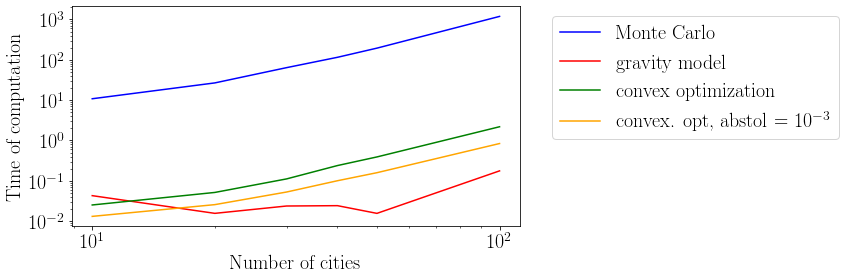

In [158]:
# computation time for all 3 methods
plt.figure(figsize = (12,4))
plt.yscale('log')
plt.xscale('log')
plt.plot(np.array([10, 20, 30, 40, 50, 100]), time_MonteCarlo_1, color = 'blue', label = 'Monte Carlo')
plt.plot(np.array([10, 20, 30, 40, 50, 100]), time_Gravity_1, color = 'red', label = 'gravity model')   
plt.plot(np.array([10, 20, 30, 40, 50, 100]), [0.025159597396850586, 0.05145668983459473, 0.11138153076171875,
 0.23868942260742188, 0.3904895782470703, 2.187985420227051], color = 'green', \
         label = 'convex optimization')
plt.plot(np.array([10, 20, 30, 40, 50, 100]), [0.013119935989379883, 0.02564549446105957, 0.05269312858581543,\
 0.10037827491760254, 0.15876126289367676, 0.8394811153411865], color = 'orange', \
         label = 'convex. opt, abstol = $10^{-3}$')
plt.xlabel(r"Number of cities", size = 20)
plt.ylabel(r"Time of computation", size = 20)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks( fontsize=20)
plt.tight_layout()
#plt.savefig('time_O=D=1000_coords_constant.png')

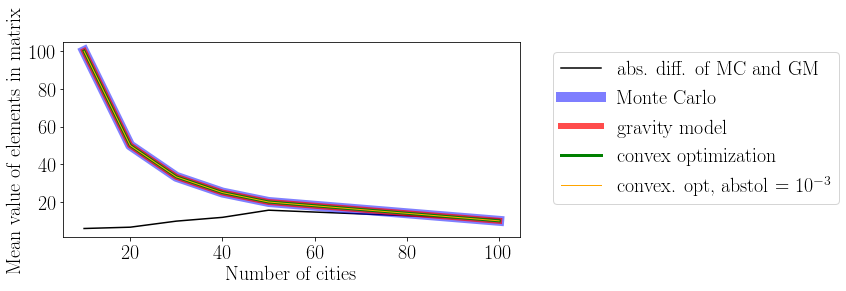

In [160]:
# mean element of matrices of all 3 methods
plt.figure(figsize = (12,4))
plt.plot( np.array([10, 20, 30, 40, 50, 100]), abs_difference_1, color = 'black', label = 'abs. diff. of MC and GM')
plt.plot( np.array([10, 20, 30, 40, 50, 100]), mean_T_sum_1, color = 'blue', label = 'Monte Carlo',\
         linewidth = 10, alpha = 0.5)
plt.plot( np.array([10, 20, 30, 40, 50, 100]), mean_T_1, color = 'red', label = 'gravity model', \
        linewidth = 6, alpha = 0.7)
plt.plot( np.array([10, 20, 30, 40, 50, 100]), [99.99999931634052, 49.99999971714758, 33.33333315722347, \
24.999999867983043, 19.999999931912726, 9.999999970033832], color = 'green',\
         label = 'convex optimization', linewidth = 3)
plt.plot( np.array([10, 20, 30, 40, 50, 100]), [99.94079059794728, 49.95400411948398, 33.30453798656983, \
 24.978497798561158, 19.982535066548067, 9.992402258881054], color = 'orange',\
         label = 'convex. opt, abstol = $10^{-3}$', linewidth = 1)
plt.xlabel(r"Number of cities", size = 20)
plt.ylabel(r"Mean value of elements in matrix", size = 20)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks( fontsize=20)
plt.tight_layout()
#plt.savefig('mean_O=D=1000_coords_constant.png')

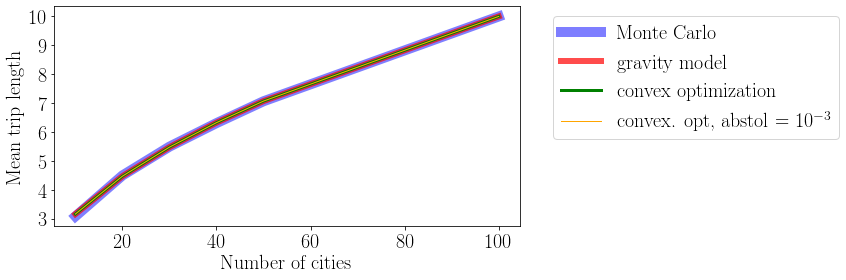

In [161]:
# mean trip length of matrices of all 3 method
plt.figure(figsize = (12,4))
plt.plot( np.array([10, 20, 30, 40, 50, 100]), length_MonteCarlo_1, color = 'blue', label ='Monte Carlo',\
         linewidth = 10, alpha = 0.5)
plt.plot( np.array([10, 20, 30, 40, 50, 100]), length_Gravity_1, color ='red', label = 'gravity model', \
        linewidth = 6, alpha = 0.7)
plt.plot( np.array([10, 20, 30, 40, 50, 100]), [3.1622776601683924, 4.472135954999571, 5.477225575051628,\
6.32455532033671, 7.071067811865458, 9.999999999999963], color ='green',\
         label = 'convex optimization', linewidth = 3)
plt.plot( np.array([10, 20, 30, 40, 50, 100]), [3.1622776601816684, 4.4721359549862205, 5.47722557503594,\
 6.3245553203323235, 7.071067811868817, 9.999999999971303], color ='orange',\
         label = 'convex. opt, abstol = $10^{-3}$', linewidth = 1)
plt.xlabel(r"Number of cities", size = 20)
plt.ylabel(r"Mean trip length", size = 20)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.savefig('length_O=D=1000_coords_constant.png')

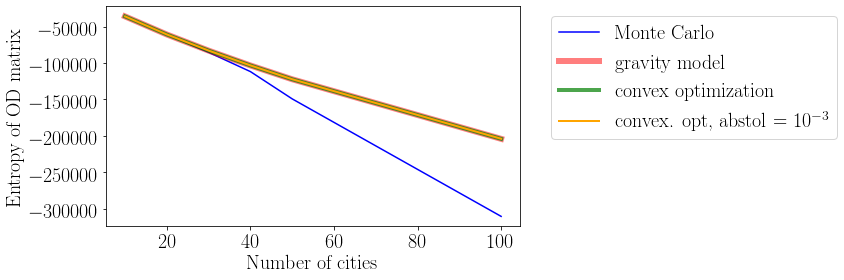

In [162]:
# entropy of matrices of all 3 methods
plt.figure(figsize = (12,4))
plt.plot( np.array([10, 20, 30, 40, 50, 100]), entropy_MonteCarlo_1, color = 'blue', label ='Monte Carlo')
plt.plot( np.array([10, 20, 30, 40, 50, 100]), entropy_Gravity_1, color ='red', label = 'gravity model', \
        linewidth=6, alpha = 0.5)
plt.plot( np.array([10, 20, 30, 40, 50, 100]), [-36072.3377025398, -60864.64504280782, -82991.314981557, \
 -103310.7588596136, -122278.8325213295, -203960.19305823438], color ='green', \
         label = 'convex optimization', linewidth=4, alpha = 0.7)
plt.plot( np.array([10, 20, 30, 40, 50, 100]), [-36056.22260803197, -60825.202856156124, -82940.48932032137, \
 -103246.3750601264, -122200.40819449126, -203850.76225518048], color ='orange', \
         label = 'convex. opt,  abstol = $10^{-3}$', linewidth=2)
plt.xlabel(r"Number of cities", size = 20)
plt.ylabel(r"Entropy of OD matrix", size = 20)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.savefig('entropy_O=D=1000_coords_constant.png')

In [165]:
# linear growth of population and constant spacing of zones on the streight line
seed = 123
num_cities = 10
max_size = 2000
type_coords = 'konstant'
coef = 1
distance_of_cities = 0.8
start_it = 1000000
max_it = 3000000
type_OD = 'O=D_linear'
OD_relation = 'not_equal'

In [166]:
# calculation of Monte Carlo and gravity matrix
time_MonteCarlo_2 = []
time_Gravity_2 = []
abs_difference_2 = []
relat_difference_2 = []
mean_T_sum_2 = []
mean_T_2 = []
length_2 = []
length_MonteCarlo_2 = []
length_Gravity_2 = []
entropy_MonteCarlo_2 = []
entropy_Gravity_2 = []
j = 0
for a in np.array([10, 20, 30, 40, 50, 100]):

    max_it = 2000000 + 3*(a-10)*10000
    O, D = population_of_cities(type_OD, max_size, a, OD_relation)

    x,y = generation_of_coordinates(seed, a, type_coords, coef, distance_of_cities)

    d = distance_matrix_d(x,y)
    
    wanted_avg_length = np.sqrt(a)

    T = initial_matrix_T(seed, a, O, D, d, wanted_avg_length)
    

    start_time = time.time()
    T, demon, entropia, acc, T_sum = generation_OD(seed, O, D, d,T, wanted_avg_length, max_it, start_it)
    end_time = time.time()
    print(end_time-start_time)
    time_MonteCarlo_2.append(end_time-start_time)
    if (O == D).all():
        T_sum = (T_sum +np.transpose(T_sum))/2
    
    
    start_time = time.time()
    chyba, it, entropia_2, T_2, O_2, d_2, beta = gravity_model( O, D, d, OD_relation, 1, wanted_avg_length)
    end_time = time.time()
    time_Gravity_2.append(end_time-start_time)
    
    
    abs_difference_2.append(abs(T_sum-T_2).mean())
    relat_difference_2.append((abs(T_sum-T_2)/T_2).mean())
    mean_T_sum_2.append(T_sum.mean())
    mean_T_2.append(T_2.mean())
    length_2.append(wanted_avg_length)
    length_MonteCarlo_2.append(np.sum(d*T_sum)/np.sum(T_sum))
    length_Gravity_2.append(np.sum(d*T_2)/np.sum(T_2))
    entropy_MonteCarlo_2.append(entropy_function(T_sum))
    entropy_Gravity_2.append(entropy_function(T_2))
    j += 1 

908096
7.543880462646484
1957195
28.183027029037476
2212182
63.54614615440369
2468197
122.85993576049805
2723784
202.31992268562317
3992677
1073.2021946907043


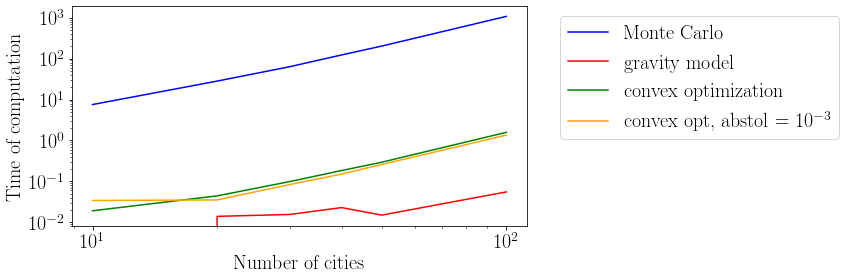

In [188]:
# computation time for all 3 methods
plt.figure(figsize=(12,4))
plt.yscale('log')
plt.xscale('log')
plt.plot(np.array([10, 20, 30, 40, 50, 100]), time_MonteCarlo_2, color = 'blue', label = 'Monte Carlo')
plt.plot(np.array([10, 20, 30, 40, 50, 100]), time_Gravity_2, color = 'red', label = 'gravity model')   
plt.plot(np.array([10, 20, 30, 40, 50, 100]), [0.01916956901550293, 0.04434657096862793, 0.09931111335754395,\
 0.18461155891418457, 0.2946505546569824, 1.5789926052093506], color = 'green', \
         label = 'convex optimization')
plt.plot(np.array([10, 20, 30, 40, 50, 100]), [0.03422904014587402, 0.035298824310302734, 0.08402895927429199,\
 0.15102744102478027, 0.2593843936920166, 1.3488852977752686], color = 'orange', \
         label = 'convex opt, abstol = $10^{-3}$')
plt.xlabel(r"Number of cities", size = 20)
plt.ylabel(r"Time of computation", size = 20)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.savefig('time_O=D_linear_coords_constant.png')

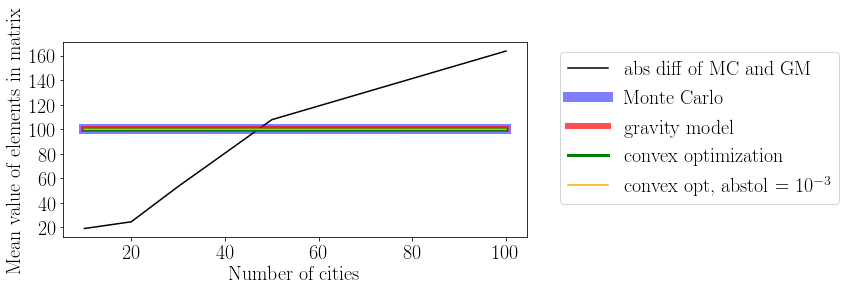

In [185]:
# mean element of matrices of all 3 methods
plt.figure(figsize = (12,4))
plt.plot(np.array([10, 20, 30, 40, 50, 100]), abs_difference_2, color = 'black', label ='abs diff of MC and GM')
plt.plot( np.array([10, 20, 30, 40, 50, 100]), mean_T_sum_2, color = 'blue', label ='Monte Carlo', \
        linewidth = 10, alpha = 0.5)
plt.plot( np.array([10, 20, 30, 40, 50, 100]), mean_T_2, color = 'red', label = 'gravity model',\
         linewidth = 6, alpha = 0.7 )
plt.plot( np.array([10, 20, 30, 40, 50, 100]), [99.99999917681535, 99.99999966368237, 99.99999958742235, \
 99.99999933935652, 99.999999383372, 99.99999969315358], color = 'green',\
         label = 'convex optimization', linewidth = 3)
plt.plot(np.array([10, 20, 30, 40, 50, 100]), [99.95827062827927, 99.9447168602551, 99.9324337129277, \
 99.95599654914344, 99.95905945704752, 99.93038614361056], color = 'orange', \
         label = 'convex opt, abstol = $10^{-3}$')
plt.xlabel(r"Number of cities", size = 20)
plt.ylabel(r'Mean value of elements in matrix', size = 20)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks( fontsize=20)
plt.tight_layout()
#plt.savefig('mean_O=D_linear_coords_constant.png')

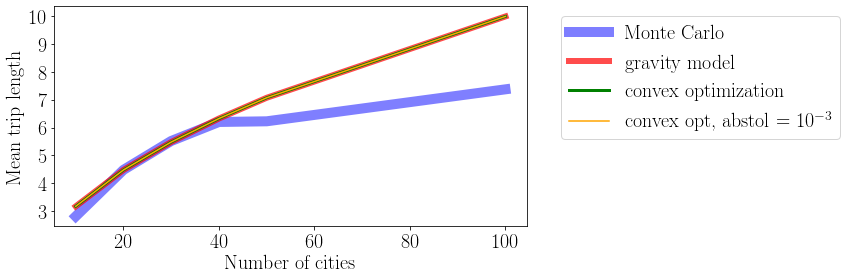

In [190]:
# mean trip length of matrices of all 3 methods
plt.figure(figsize=(12,4))
plt.plot( np.array([10, 20, 30, 40, 50, 100]), length_MonteCarlo_2, color = 'blue', label ='Monte Carlo',\
         linewidth = 10, alpha = 0.5)
plt.plot( np.array([10, 20, 30, 40, 50, 100]), length_Gravity_2, color ='red', label = 'gravity model',\
        linewidth = 6, alpha = 0.7)
plt.plot( np.array([10, 20, 30, 40, 50, 100]), [3.1622776601683777, 4.472135954999581, 5.477225575051656,\
 6.324555320336755, 7.0710678118654835, 10.00000000000001], color ='green',\
         label = 'convex optimization', linewidth = 3)
plt.plot(np.array([10, 20, 30, 40, 50, 100]), [3.1622776601745985, 4.472135954997144, 5.47722557504408, \
 6.324555320333563, 7.071067811867065, 9.999999999989692], color = 'orange', \
         label = 'convex opt, abstol = $10^{-3}$')
plt.xlabel(r"Number of cities", size = 20)
plt.ylabel(r"Mean trip length", size = 20)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks( fontsize=20)
plt.tight_layout()
#plt.savefig('length_O=D_linear_coords_constant.png')

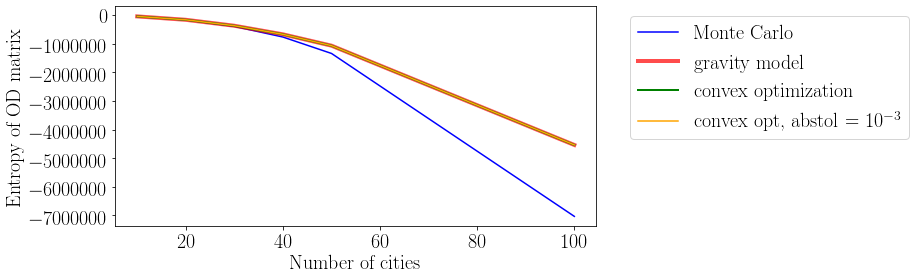

In [193]:
# entropy of matrices of all 3 methods
plt.figure(figsize=(13,4))
plt.plot( np.array([10, 20, 30, 40, 50, 100]), entropy_MonteCarlo_2, color = 'blue', label ='Monte Carlo')
plt.plot( np.array([10, 20, 30, 40, 50, 100]), entropy_Gravity_2, color ='red', label = 'gravity model', \
        linewidth = 4, alpha = 0.7)
plt.plot( np.array([10, 20, 30, 40, 50, 100]), [-38239.178466742334, -157281.18976079172, -365277.9838752972,\
 -665998.6751554558, -1062128.8733331885, -4536122.840607372],color ='green',\
         label = 'convex optimization', linewidth = 2)
plt.plot(np.array([10, 20, 30, 40, 50, 100]), [-38227.8620326249, -157221.00359372297, -365109.7034102717, \
 -665796.5475871867, -1061825.6868425717, -4533987.691334602], color = 'orange', \
         label = 'convex opt, abstol = $10^{-3}$')
plt.xlabel(r"Number of cities", size = 20)
plt.ylabel(r"Entropy of OD matrix", size = 20)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks( fontsize=20)
plt.tight_layout()
#plt.savefig('entropy_O=D_linear_coords_constant.png')

In [24]:
# constant population and normal random distribution of zones
seed = 123
num_cities = 10
max_size = 2000
type_coords = 'nahodne'
coef = 1
distance_of_cities = 0.8
start_it = 1000000
max_it = 3000000
type_OD = 'O=D=1000'
OD_relation = 'equal'

In [25]:
# computation of Monte Carlo and gravity matrix 
time_MonteCarlo_3 = []
time_Gravity_3 = []
abs_difference_3 = []
relat_difference_3 = []
length_3 = []
mean_T_sum_3 = []
mean_T_3 = []
length_MonteCarlo_3 = []
length_Gravity_3 = []
entropy_MonteCarlo_3 = []
entropy_Gravity_3 = []
j = 0
for a in np.array([10, 20, 30, 40, 50, 100]):
    max_it = 2000000 + 3*(a-10)*10000
# velkost miest(pocet obyvatelov) 
    O, D = population_of_cities(type_OD, max_size, a, OD_relation)

# rovnomerne sa zvacsujuca vzdialenost medzi mestami na priamke
    x,y = generation_of_coordinates(seed, a, type_coords, coef, distance_of_cities)

#   matica vzdialenosti (Euklidovska norma)
    d = distance_matrix_d(x,y)
    
    wanted_avg_length = np.sqrt(d.max())
# matica OD
    T = initial_matrix_T(seed, a, O, D, d, wanted_avg_length)

    start_time = time.time()
    T, demon, entropia, acc, T_sum = generation_OD(seed, O, D, d, T,wanted_avg_length, max_it, start_it)
    end_time = time.time()
    print(end_time-start_time)
    time_MonteCarlo_3.append(end_time-start_time)
    if (O == D).all():
        T_sum = (T_sum +np.transpose(T_sum))/2
    
    
    start_time = time.time()
    chyba, it, entropia_2, T_2, O_2, d_2, beta = gravity_model( O, D, d, OD_relation, 1, wanted_avg_length)
    end_time = time.time()
    time_Gravity_3.append(end_time-start_time)
    
    
    abs_difference_3.append(abs(T_sum-T_2).mean())
    relat_difference_3.append((abs(T_sum-T_2)/T_2).mean())
    mean_T_sum_3.append(T_sum.mean())
    mean_T_3.append(T_2.mean())
    length_3.append(wanted_avg_length)
    length_MonteCarlo_3.append(np.sum(d*T_sum)/np.sum(T_sum))
    length_Gravity_3.append(np.sum(d*T_2)/np.sum(T_2))
    entropy_MonteCarlo_3.append(entropy_function(T_sum))
    entropy_Gravity_3.append(entropy_function(T_2))
    j += 1 


9.880112171173096


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-25-9f2188c7b184>", line 27, in <module>
    T = initial_matrix_T(seed, a, O, D, d, wanted_avg_length)
  File "<ipython-input-11-49b14ce79b9c>", line 75, in initial_matrix_T
    column = np.random.randint(0,num_cities)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\ultratb.py", line 1151, in get_record

KeyboardInterrupt: 

In [ ]:
# computation time for all 3 methods
plt.figure(figsize=(12,4))
plt.yscale('log')
plt.xscale('log')
plt.plot(np.array([10, 20, 30, 40, 50, 100]), time_MonteCarlo_3, color = 'blue', label = 'Monte Carlo')
plt.plot(np.array([10, 20, 30, 40, 50, 100]), time_Gravity_3, color = 'red', label = 'gravity model')   
plt.plot(np.array([10, 20, 30, 40, 50, 100]), [0.04363536834716797, 0.06516122817993164, 0.15315890312194824,
 0.31966519355773926, 0.5153493881225586, 2.460331678390503], color = 'green', \
         label = 'convex optimization')
plt.plot(np.array([10, 20, 30, 40, 50, 100]), [0.039208173751831055, 0.04611372947692871, 0.11480522155761719,
 0.23448419570922852, 0.3796424865722656, 2.2523670196533203], color = 'orange', \
         label = 'convex opt, abstol = $10^{-3}$')
plt.xlabel(r"Number of cities", size = 20)
plt.ylabel(r"Time of computation", size = 20)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.savefig('time_O=D=1000_coords_random.png')

In [ ]:
# mean element of matrices for all 3 methods
plt.figure(figsize=(12,4))
plt.plot(np.array([10, 20, 30, 40, 50, 100]), abs_difference_3, color = 'black', label ='abs diff of MC a GM')
plt.plot( np.array([10, 20, 30, 40, 50, 100]), mean_T_sum_3, color = 'blue', label ='Monte Carlo',\
        linewidth = 10, alpha = 0.5)
plt.plot( np.array([10, 20, 30, 40, 50, 100]), mean_T_3, color = 'red', label = 'gravity model', \
        linewidth = 6, alpha = 0.7)
plt.plot( np.array([10, 20, 30, 40, 50, 100]), [99.9999990802391, 49.99999976218129, 33.33333323073915,
 24.99999989183083, 19.999999935964656, 9.999999975150974], color = 'green', \
         label = 'convex optimization', linewidth = 3)
plt.plot(np.array([10, 20, 30, 40, 50, 100]), [99.93987131536156, 49.95863773655139, 33.303835367452386,
 24.976146672177137, 19.979724019524397, 9.993352117466246], color = 'orange', \
         label = 'convex opt., abstol = $10^{-3}$', linewidth = 1)
plt.xlabel(r"Number of cities", size = 20)
plt.ylabel(r"Mean value of elements in matrix", size = 20)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.savefig('mean_O=D=1000_coords_random.png')

In [ ]:
# the mean trip length of matrix for all 3 methods
plt.figure(figsize=(12,4))
plt.plot( np.array([10, 20, 30, 40, 50, 100]), length_MonteCarlo_3, color = 'blue', label ='Monte Carlo',\
        linewidth = 10, alpha = 0.5)
plt.plot( np.array([10, 20, 30, 40, 50, 100]), length_Gravity_3, color ='red', label = 'gravity model',\
        linewidth = 6, alpha = 0.7)
plt.plot( np.array([10, 20, 30, 40, 50, 100]), [15.585571360515392, 15.404861217026337, 16.32450937427306,
 16.770386744267824, 16.13715731638147, 17.829277014860374], color ='green',\
         label = 'convex optimization', linewidth = 3)
plt.plot(np.array([10, 20, 30, 40, 50, 100]), [15.585571359954876, 15.404861216471163, 16.32450937385301,
 16.77038674386507, 16.13715731609618, 17.82927701475414], color = 'orange', \
         label = 'convex opt, abstol = $10^{-3}$', linewidth = 1)
plt.xlabel(r"Number of cities", size = 20)
plt.ylabel(r"Mean trip length", size = 20)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.savefig('length_O=D=1000_coords_random.png')

In [ ]:
# entropy of matrices for all 3 methods
plt.figure(figsize=(12,4))
plt.plot( np.array([10, 20, 30, 40, 50, 100]), entropy_MonteCarlo_3, color = 'blue', label ='Monte Carlo')
plt.plot( np.array([10, 20, 30, 40, 50, 100]), entropy_Gravity_3, color ='red', label = 'gravity model',\
        linewidth = 6, alpha = 0.5)
plt.plot( np.array([10, 20, 30, 40, 50, 100]), [-49300.89129824403, -92419.23419161905, -128589.58950400395,
 -165396.94170771664, -201203.00937409274, -334401.3553616439], color ='green',\
         label = 'convex optimization', linewidth = 3, alpha = 0.7)
plt.plot(np.array([10, 20, 30, 40, 50, 100]), [-49280.559211446394, -92366.71372504237, -128508.48980983417,\
 -165283.29317599162, -201053.30499745815, -334233.570595613], color = 'orange', \
         label = 'convex opt, abstol = $10^{-3}$', linewidth = 1)
plt.xlabel(r"Number of cities", size = 20)
plt.ylabel(r"Entropy of OD matrix", size = 20)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.savefig('entropy_O=D=1000_coords_random.png')

# Scaling for bigger systems

In [198]:
seed = 123
num_cities = 100
max_size = 2000
type_coords = 'konstant'
coef = 1
distance_of_cities = 0.8
wanted_avg_length = 10
c_star = 10
type_OD = 'O=D=1000'
OD_relation = 'equal'


In [199]:
time_Gravity_1 = []
mean_T_1 = []
length_Gravity_1 = []
entropy_Gravity_1 = []
j = 0
for a in np.array([10, 20, 40, 50, 100, 200, 500, 750, 1000, 1500]):
# velkost miest(pocet obyvatelov) 
    print(a)
    O, D = population_of_cities(type_OD, max_size, a, OD_relation)

# rovnomerne sa zvacsujuca vzdialenost medzi mestami na priamke
    x,y = generation_of_coordinates(seed, a, type_coords, coef, distance_of_cities)

#   matica vzdialenosti (Euklidovska norma)
    d = distance_matrix_d(x,y)
    
    wanted_avg_length = np.sqrt(a)
    
    
    start_time = time.time()
    chyba, it, entropia_2, T_2, O_2, d_2, beta = gravity_model( O, D, d, OD_relation, 1, wanted_avg_length)
    end_time = time.time()
    time_Gravity_1.append(end_time-start_time)
    
    
    mean_T_1.append(T_2.mean())
    length_Gravity_1.append(np.sum(d*T_2)/np.sum(T_2))
    entropy_Gravity_1.append(entropy_function(T_2))
    print(end_time-start_time)
    j += 1 

10
0.009801864624023438
20
0.011236429214477539
40
0.016618967056274414
50
0.020329713821411133
100
0.06766557693481445
200
0.19534969329833984
500
2.4377923011779785
750
5.46403169631958
1000
10.680781602859497
1500
27.645978450775146


In [200]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def time_gravity_constant(x, k, a, c):
    return a*(np.log(np.log(x)))**k + c

x = np.array([10, 20, 40, 50, 100, 200, 500, 750, 1000, 1500])
y =  np.array([0.04764819145202637, 0.03979229927062988,\
 0.13144207000732422, 0.21955108642578125, 1.1251606941223145, 5.263031959533691, 44.10571002960205, \
 125.1362669467926, 321.85312485694885, 939.5307450294495])
y2 = np.array([0.031124114990234375,
 0.030490875244140625, 0.10863351821899414, 0.18131279945373535, 0.8926191329956055, 4.368941783905029, 39.3675262928009,\
103.59759855270386, 238.79800653457642, 798.7168862819672])
popt, pcov = curve_fit(time_gravity_constant, x, time_Gravity_1, maxfev = 10000)
popt2, pcov2 = curve_fit(time_gravity_constant, x, y, maxfev = 10000)
popt3, pcov3 = curve_fit(time_gravity_constant, x, y2, maxfev = 10000)

print(popt)
print(sum((popt[1]*np.log(np.log(x))**popt[0] + popt[2]-time_Gravity_1 )**2))
print(popt2)
print(sum((popt2[1]*np.log(np.log(x))**popt2[0]+ popt2[2] -y )**2))
print(popt3)
print(sum((popt3[1]*np.log(np.log(x))**popt3[0]+ popt3[2] - y2)**2))

[3.18885173e+01 8.15139411e-09 9.44244459e-02]
0.40019742933944213
[3.76676389e+01 5.22862524e-09 9.10481626e-01]
224.56789058009323
[4.08580649e+01 4.92769236e-10 2.63328602e+00]
234.27522447208736


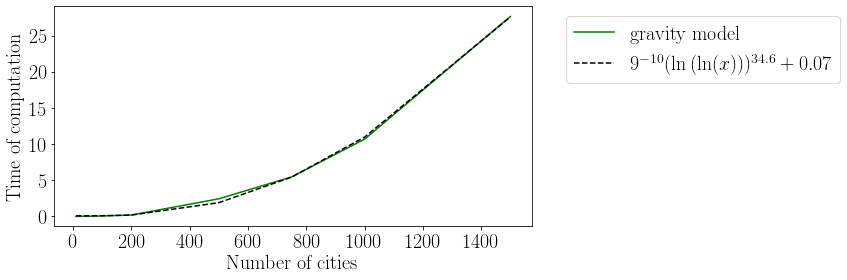

In [201]:
plt.figure(figsize=(12,4))

plt.plot(x, time_Gravity_1, color = 'green', label = 'gravity model')
plt.plot(x, popt[1]*np.log(np.log(x))**popt[0]+popt[2], label = '$9^{-10}(\ln{(\ln({x}))})^{34.6}+0.07$', color = 'black',\
        linestyle = '--')
plt.xlabel(r"Number of cities", size = 20)
plt.ylabel(r"Time of computation", size = 20)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.savefig('aprox_gravity.png')

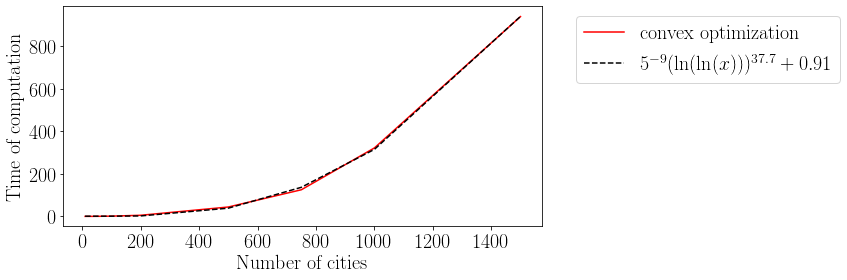

In [202]:
plt.figure(figsize=(12,4))

plt.plot(x, y, color = 'red', label='convex optimization')
plt.plot(x, popt2[1]*np.log(np.log(x))**popt2[0]+popt2[2], label = '$5^{-9}(\ln({\ln({x})}))^{37.7}+0.91$', color = 'black',\
        linestyle = '--')
plt.xlabel(r"Number of cities", size = 20)
plt.ylabel(r"Time of computation", size = 20)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.savefig('aprox_convex.png')

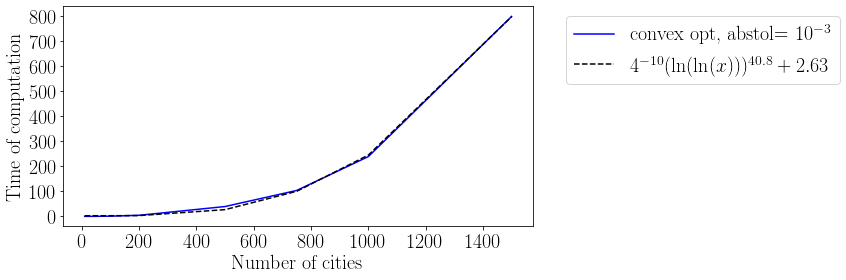

In [232]:
plt.figure(figsize=(12,4))
plt.plot(x, y2, color = 'blue', label='convex opt, abstol= $10^{-3}$')
plt.plot(x, popt3[1]*np.log(np.log(x))**popt3[0]+popt3[2], label = '$4^{-10}(\ln({\ln({x})}))^{40.8}+2.63$', color = 'black',
        linestyle = '--')
plt.xlabel(r"Number of cities", size = 20)
plt.ylabel(r"Time of computation", size = 20)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.savefig('aprox_convex_feastol.png')

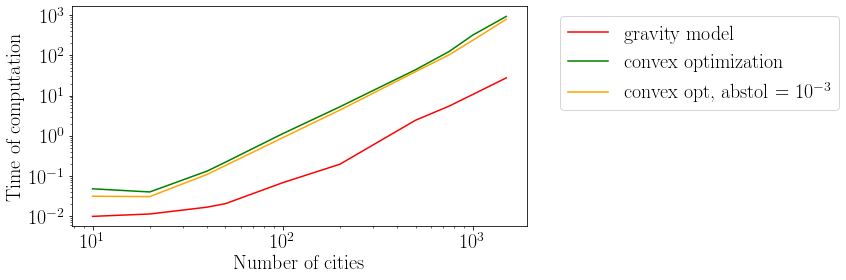

In [226]:
plt.figure(figsize = (12,4))
plt.yscale('log')
plt.xscale('log')
plt.plot(x, time_Gravity_1, color = 'red', label = 'gravity model')   
plt.plot(x, [0.04764819145202637, 0.03979229927062988,\
 0.13144207000732422, 0.21955108642578125, 1.1251606941223145, 5.263031959533691, 44.10571002960205, \
 125.1362669467926, 321.85312485694885, 939.5307450294495], color = 'green', label = 'convex optimization')
plt.plot(x, [0.031124114990234375,
 0.030490875244140625, 0.10863351821899414, 0.18131279945373535, 0.8926191329956055, 4.368941783905029, 39.3675262928009,\
103.59759855270386, 238.79800653457642, 798.7168862819672], color = 'orange',\
         label = 'convex opt, abstol = $10^{-3}$')
plt.xlabel(r"Number of cities", size = 20)
plt.ylabel(r"Time of computation", size = 20)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks( fontsize=20)
plt.tight_layout()
#plt.savefig('time_O=D=1000_coords_constant_big_sys.png')

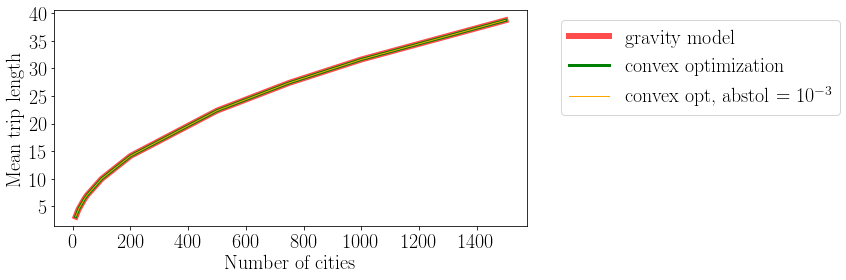

In [227]:
plt.figure(figsize=(12,4))
plt.plot( x, length_Gravity_1, color ='red', label = 'gravity model',\
        linewidth = 6, alpha = 0.7)
plt.plot( x, [3.1622776601683884, 4.472135954999574, 6.324555320336724,\
 7.0710678118654595, 9.999999999999963, 14.142135623731082, 22.360679774997564, 27.38612787525862, 31.622776601682276,\
 38.72983346207652], color ='green', label = 'convex optimization', linewidth = 3)
plt.plot(x, [3.1622776601816684, 4.4721359549862205, 6.3245553203323235,\
 7.071067811868817, 9.999999999971303, 14.142135623706189, 22.360679775029837, 27.38612787534961, 31.622776601761604, \
 38.729833462133996], color = 'orange',label = 'convex opt, abstol = $10^{-3}$', linewidth = 1)
plt.xlabel(r"Number of cities", size = 20)
plt.ylabel(r"Mean trip length", size = 20)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.savefig('length_O=D=1000_coords_constant_big_sys.png')

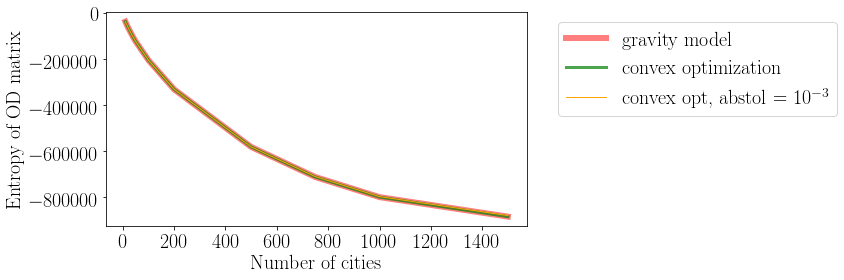

In [228]:
plt.figure(figsize=(12,4))
plt.plot( x, entropy_Gravity_1, color ='red', label = 'gravity model',\
        linewidth = 6, alpha = 0.5)
plt.plot( x, [-36072.3377025398, -60864.64504280782, -103310.7588596136,\
 -122278.8325213295, -203960.19305823438, -330755.37920061534, -581122.0760886666, -711906.8255642863,\
 -799276.7412492762, -884048.3158600524], color ='green', label = 'convex optimization', linewidth = 3, alpha = 0.7)
plt.plot(x, [-36056.22260803197, -60825.202856156124, -103246.3750601264,\
 -122200.40819449126, -203850.76225518048, -330594.54847708344, -580797.5609614945, -709914.7074088054, \
 -796965.2440981135, -879484.3612595816], color = 'orange', label = 'convex opt, abstol = $10^{-3}$',\
         linewidth = 1)
plt.xlabel(r"Number of cities", size = 20)
plt.ylabel(r"Entropy of OD matrix", size = 20)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.savefig('entropy_O=D=1000_coords_constant_big_sys.png')

In [207]:
seed = 123
num_cities = 10
max_size = 2000
type_coords = 'konstant'
coef = 1
distance_of_cities = 0.8
start_it = 1000000
max_it = 3000000
type_OD = 'O=D_linear'
OD_relation = 'not_equal'

In [208]:
time_Gravity_2 = []
mean_T_2 = []
length_Gravity_2 = []
entropy_Gravity_2 = []
j = 0
for a in x:
# velkost miest(pocet obyvatelov) 
    print(a)
    O, D = population_of_cities(type_OD, max_size, a, OD_relation)

# rovnomerne sa zvacsujuca vzdialenost medzi mestami na priamke
    x,y = generation_of_coordinates(seed, a, type_coords, coef, distance_of_cities)

#   matica vzdialenosti (Euklidovska norma)
    d = distance_matrix_d(x,y)
    
    wanted_avg_length = np.sqrt(a)
    
    
    start_time = time.time()
    chyba, it, entropia_2, T_2, O_2, d_2, beta = gravity_model( O, D, d, OD_relation, 1, wanted_avg_length)
    end_time = time.time()
    time_Gravity_2.append(end_time-start_time)
    
    
    mean_T_2.append(T_2.mean())
    length_Gravity_2.append(np.sum(d*T_2)/np.sum(T_2))
    entropy_Gravity_2.append(entropy_function(T_2))
    print(end_time-start_time)
    j += 1 

10
0.02218937873840332
20
0.017594099044799805
40
0.04689311981201172
50
0.02468276023864746
100
0.07316088676452637
200
0.18781423568725586
500
2.4361348152160645
750
6.807528495788574
1000
10.514459609985352
1500
27.904743432998657


In [209]:
x = np.array([10, 20, 40, 50, 100, 200, 500, 750, 1000, 1500])

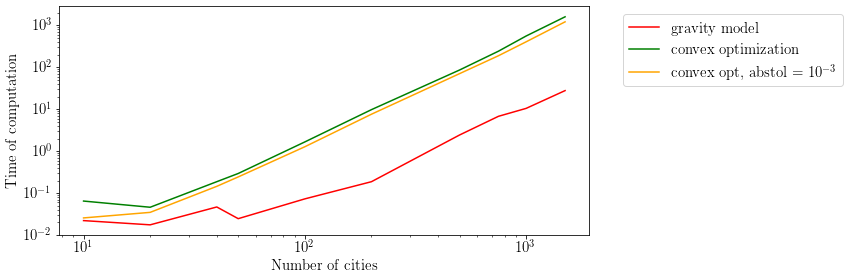

In [229]:
plt.figure(figsize = (12,4))
plt.yscale('log')
plt.xscale('log')
plt.plot(x, time_Gravity_2, color = 'red', label = 'gravity model')   
plt.plot(x, [0.06487536430358887, 0.046195268630981445, 0.18804097175598145, 0.2949192523956299, \
 1.6681764125823975, 9.809273958206177, 86.34082770347595, 243.11367321014404, 558.8573088645935,
 1604.6058733463287], color = 'green', label = 'convex optimization')
plt.plot(x, [0.025708675384521484, 0.034882307052612305, 0.14562010765075684, 0.24419260025024414, 1.2793242931365967, \
 7.632089853286743, 70.69959306716919, 189.29969143867493, 406.44550132751465, 1217.6107304096222],\
         color = 'orange', label = 'convex opt, abstol = $10^{-3}$')
plt.xlabel(r"Number of cities", size = 15)
plt.ylabel(r"Time of computation", size = 15)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks( fontsize=15)
plt.tight_layout()
#plt.savefig('time_O=D_linear_coords_constant_big_sys.png')

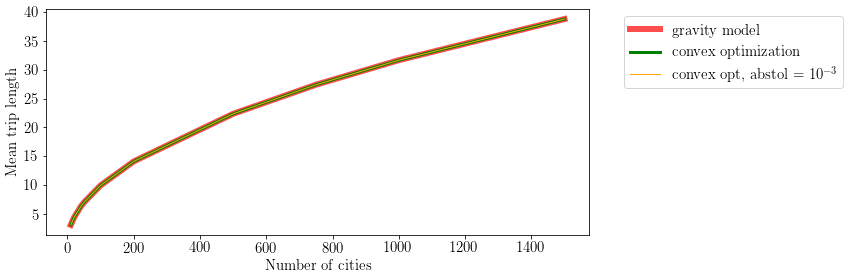

In [230]:
plt.figure(figsize=(12,4))
plt.plot( x, length_Gravity_2, color ='red', label = 'gravity model',\
        linewidth = 6, alpha = 0.7)
plt.plot( x, [3.1622776601683777, 4.472135954999581, 6.324555320336755, 7.0710678118654835, 10.00000000000001, \
 14.14213562373096, 22.360679774997944, 27.38612787525782, 31.62277660168392, 38.7298334620728],\
         color ='green', label = 'convex optimization', linewidth = 3)
plt.plot(x, [3.1622776601745985, 4.472135954997144, 6.324555320333563, 7.071067811867065, 9.999999999989692, \
 14.142135623719653, 22.36067977499286, 27.386127875248377, 31.622776601673138, 38.72983346206546], color = 'orange',\
         label = 'convex opt, abstol = $10^{-3}$', linewidth = 1)
plt.xlabel(r"Number of cities", size = 15)
plt.ylabel(r"Mean trip length", size = 15)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
#plt.savefig('length_O=D_linear_coords_constant_big_sys.png')

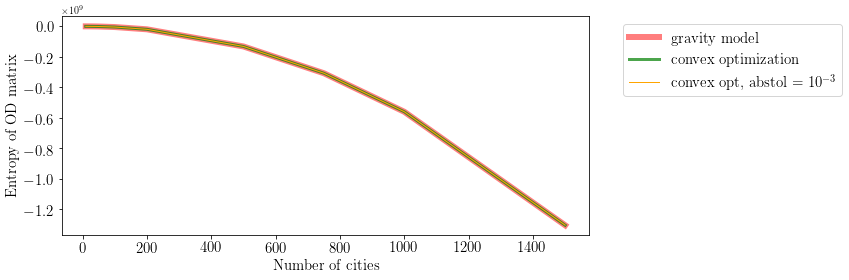

In [231]:
plt.figure(figsize=(12,4))
plt.plot( x, entropy_Gravity_2, color ='red', label = 'gravity model',\
        linewidth = 6, alpha = 0.5)
plt.plot(x, np.array([-38239.178466742334, -157281.18976079172, -665998.6751554558, -1062128.8733331885,\
 -4536122.840607372, -19374317.298936892, -131703694.4762312, -307150569.2181029, -559811899.2209148, \
 -1303551699.5602384]), color ='green', label = 'convex optimization', linewidth = 3, alpha = 0.7)
plt.plot(x, [-38227.8620326249, -157221.00359372297, -665796.5475871867, -1061825.6868425717, -4533987.691334602,\
 -19363302.412004944, -131673470.66758573, -306973709.5457156, -559489166.2609211, -1302795935.726053],\
         color = 'orange', label = 'convex opt, abstol = $10^{-3}$',\
         linewidth = 1)
plt.xlabel(r"Number of cities", size = 15)
plt.ylabel(r"Entropy of OD matrix", size = 15)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
#plt.savefig('entropy_O=D_linear_coords_constant_big_sys.png')

In [26]:
seed = 123
num_cities = 10
max_size = 2000
type_coords = 'nahodne'
coef = 1
distance_of_cities = 0.8
start_it = 1000000
max_it = 3000000
type_OD = 'O=D=1000'
OD_relation = 'equal'

In [27]:
time_Gravity_3 = []
mean_T_3 = []
length_Gravity_3 = []
entropy_Gravity_3 = []
j = 0
for a in np.array([10, 20, 40, 50, 100, 200, 500, 750, 1000, 1500]):
# velkost miest(pocet obyvatelov) 
    print(a)
    O, D = population_of_cities(type_OD, max_size, a, OD_relation)

# rovnomerne sa zvacsujuca vzdialenost medzi mestami na priamke
    x,y = generation_of_coordinates(seed, a, type_coords, coef, distance_of_cities)

#   matica vzdialenosti (Euklidovska norma)
    d = distance_matrix_d(x,y)
    
    wanted_avg_length = np.sqrt(d.max())
    
    
    start_time = time.time()
    chyba, it, entropia_2, T_2, O_2, d_2, beta = gravity_model( O, D, d, OD_relation, 1, wanted_avg_length)
    end_time = time.time()
    time_Gravity_3.append(end_time-start_time)
    
    
    mean_T_3.append(T_2.mean())
    length_Gravity_3.append(np.sum(d*T_2)/np.sum(T_2))
    entropy_Gravity_3.append(entropy_function(T_2))
    print(end_time-start_time)
    j += 1 

10
0.022016048431396484
20
0.01399993896484375
40
0.014022350311279297
50
0.020994186401367188
100
0.08799862861633301
200
0.16556525230407715
500
1.7017533779144287
750
4.910265207290649
1000
11.286992073059082
1500
30.1539363861084


In [28]:
x = np.array([10, 20, 40, 50, 100, 200, 500, 750, 1000, 1500])

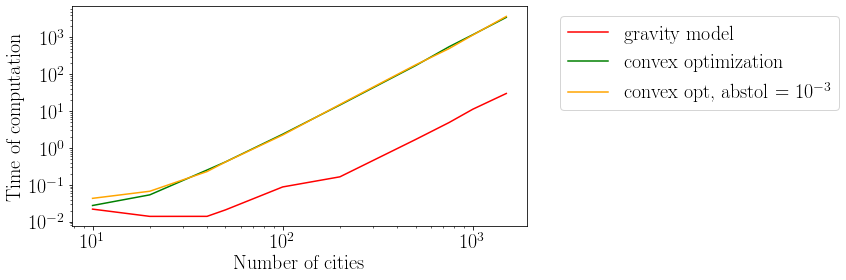

In [39]:
plt.figure(figsize = (12,4))
plt.yscale('log')
plt.xscale('log')
plt.plot(x, time_Gravity_3, color = 'red', label = 'gravity model')   
plt.plot(x, [0.02762293815612793, 0.05368971824645996, 0.2530972957611084, 0.41989970207214355, 2.371194839477539,\
             14.656854629516602, 171.91375470161438, 558.0112898349762, 1183.2800755500793, 3498.430337667465], \
         color = 'green', label = 'convex optimization')
plt.plot(x, [0.043179988861083984, 0.06725454330444336, 0.2297685146331787, 0.4174778461456299, \
 2.2513537406921387, 15.16953182220459, 179.63801336288452, 496.68900299072266, 1158.8949387073517, \
 3713.7706532478333], color = 'orange', label = 'convex opt, abstol = $10^{-3}$')
plt.xlabel(r"Number of cities", size = 20)
plt.ylabel(r"Time of computation", size = 20)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks( fontsize=20)
plt.tight_layout()
#plt.savefig('time_O=D=1000_coords_random_big_sys.png')

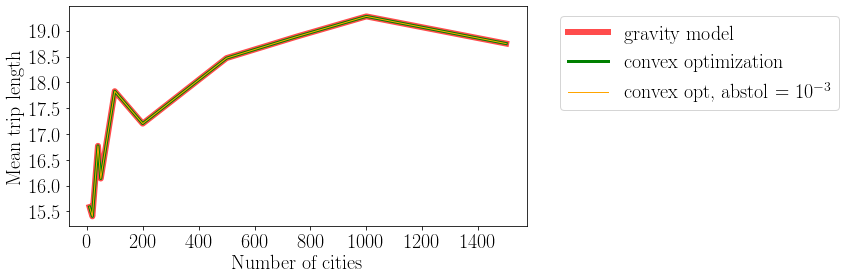

In [40]:
plt.figure(figsize=(12,4))
plt.plot( x, length_Gravity_3, color ='red', label = 'gravity model',linewidth = 6, alpha = 0.7)
plt.plot( x, [15.585571360515392, 15.404861217026337, 16.770386744267824, 16.13715731638147, 17.829277014860374,\
 17.201292358696865, 18.469158700271738, 18.884275146691635, 19.277682184434198, 18.75134023547744],\
         color ='green', label = 'convex optimization', linewidth = 3)
plt.plot(x, [15.585571359954876, 15.404861216471163, 16.77038674386507, 16.13715731609618, 17.82927701475414,\
 17.20129235866437, 18.469158700305027, 18.884275146725805, 19.27768218447805, \
 18.751340235495615], color = 'orange',label = 'convex opt, abstol = $10^{-3}$', linewidth = 1)
plt.xlabel(r"Number of cities", size = 20)
plt.ylabel(r"Mean trip length", size = 20)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.savefig('length_O=D=1000_coords_random_big_sys.png')

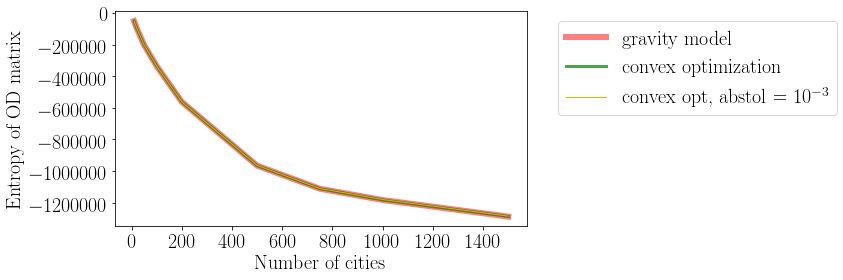

In [41]:
plt.figure(figsize=(12,4))
plt.plot( x, entropy_Gravity_3, color ='red', label = 'gravity model',linewidth = 6, alpha = 0.5)
plt.plot( x, [-49300.89129824403, -92419.23419161905, -165396.94170771664, -201203.00937409274, -334401.3553616439, \
 -561412.9871460119, -965750.4093637705, -1111974.1848265226, -1183285.7027504968, -1287946.9953779785], \
         color ='green', label = 'convex optimization', linewidth = 3, alpha = 0.7)
plt.plot(x, [-49280.559211446394, -92366.71372504237, -165283.29317599162, -201053.30499745815, -334233.570595613,\
 -561037.6956611811, -964451.3375035386, -1110754.5464328106, -1180754.2136407979, -1285839.3903702837],\
         color = 'orange', label = 'convex opt, abstol = $10^{-3}$',linewidth = 1)
plt.xlabel(r"Number of cities", size = 20)
plt.ylabel(r"Entropy of OD matrix", size = 20)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.savefig('entropy_O=D=1000_coords_random_big_sys.png')

### Convex optimization comparison

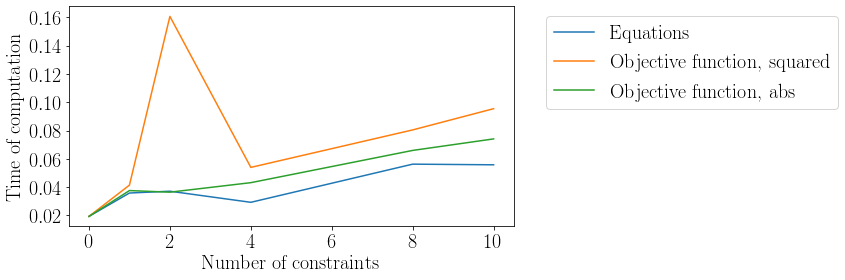

In [238]:
plt.figure(figsize=(12,4))
plt.plot([0,1,2,4,8,10], [0.019326448440551758, 0.035832881927490234, 0.0371098518371582, 0.029266357421875, \
 0.05623793601989746, 0.05578255653381348], label = 'Equations')
plt.plot([0,1,2,4,8,10], [0.019326448440551758, 0.04141664505004883, 0.16067218780517578, 0.05395030975341797,\
 0.08043789863586426, 0.0954427719116211], label = 'Objective function, squared')
plt.plot([0,1,2,4,8,10], [0.019326448440551758, 0.037568092346191406, 0.036431312561035156, 0.04315614700317383,\
                          0.06594276428222656, 0.07408547401428223], label = 'Objective function, abs')
plt.xlabel(r"Number of constraints", size = 20)
plt.ylabel(r"Time of computation", size = 20)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.savefig('convex_compare_time')

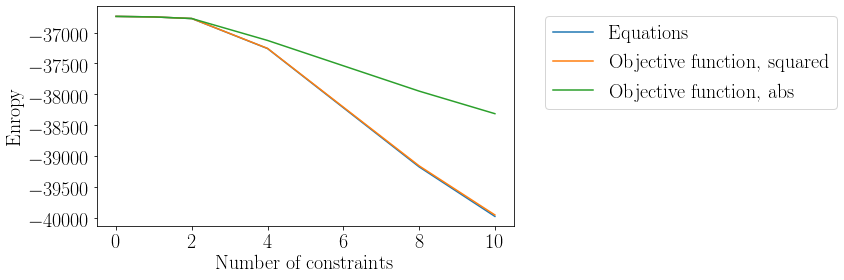

In [240]:
plt.figure(figsize=(12,4))
plt.plot([0,1,2,4,8,10], [-36738.132568841305, -36746.65155380378, -36772.81896108887, -37259.165425367726,\
 -39175.14167061108, -39977.1072463408], label = 'Equations')
plt.plot([0,1,2,4,8,10], [-36738.132568841305, -36746.57458761445, -36772.59897608441, -37256.74701432269,\
 -39158.66330201077, -39953.9852395677], label = 'Objective function, squared')
plt.plot([0,1,2,4,8,10], [-36738.132568841305, -36746.65147270903, -36772.81900637142, -37127.726335746294,\
 -37948.337065069565, -38313.72060953769], label = 'Objective function, abs')
plt.xlabel(r"Number of constraints", size = 20)
plt.ylabel(r"Enropy", size = 20)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.savefig('convex_compare_entropy.png')